In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import contextily as cx
import warnings
warnings.filterwarnings("ignore")

In [37]:
import zipfile
with zipfile.ZipFile('./0128886-210914110416597.zip', 'r') as zip_ref:
    zip_ref.extractall('./training_data/')

In [43]:
columns = [
    'gbifID',
    'eventDate',
    'countryCode',
    'stateProvince',
    'decimalLatitude',
    'decimalLongitude',
    'species',
    'verbatimScientificName'
]

country_names = {'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa'}

data = (
    pd.read_csv('./training_data/occurrence.txt', sep='\t', parse_dates=['eventDate'])
    [columns]
    [lambda x: (~x.decimalLatitude.isna()) & (~x.decimalLongitude.isna())]
    [lambda x: (x.decimalLatitude != 0.0) & (x.decimalLongitude != 0.0)]
    .assign(
        country =  lambda x: x.countryCode.map(country_names),
        species =  lambda x: x.verbatimScientificName.str.title()
    )
    .drop(['verbatimScientificName', 'countryCode'], 1)
)

np.sum(data.isna())/len(data)*100

gbifID              0.000000
eventDate           5.423446
stateProvince       0.308550
decimalLatitude     0.000000
decimalLongitude    0.000000
species             0.000000
country             0.000000
dtype: float64

In [95]:
def plot_species(fig, ax, frog_data, region_name):
    # Bar chart
    bar_data = frog_data.species.value_counts()
    barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)
    # Colour cycle to ensure colors match in both plots
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        species_name = bar_data.index[i]
        if len(species_name) > 19:
            display_name = species_name.replace(' ', '\n')
        else:
            display_name = species_name
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{display_name}\nCount: {bar_data[i]}")
        filt = frog_data.species == species_name
        # Scatter plot
        ax[0].scatter(
            frog_data[filt].decimalLongitude, 
            frog_data[filt].decimalLatitude, 
            marker='.', 
            color=color['color']
        )
    # Add other features
    ax[0].set_title(f"Frog occurrences for {region_name}")
    ax[0].set_xticklabels([])
    ax[0].set_yticklabels([])
    ax[1].set_title(f"Frog species distribution in {region_name}")
    cx.add_basemap(ax[0], crs={'init':'epsg:4326'}, alpha=0.5) # Add basemap
    ax[1].set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax[1].legend()
    return
    
    
def plot_barchart(bar_data, ax):
    barchart = ax.bar(bar_data.index, bar_data)
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        var_name = bar_data.index[i]
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{var_name}\nCount: {bar_data[i]}")
    ax.set_xticklabels(bar_data.index, rotation=45)
    ax.legend()

Text(0.5, 1.0, 'Frog occurrences by country')

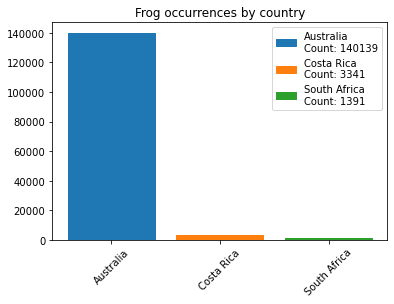

In [97]:
country_bar_data = data.country.value_counts()
fig, ax = plt.subplots()
plot_barchart(country_bar_data, ax)
ax.set_title('Frog occurrences by country')

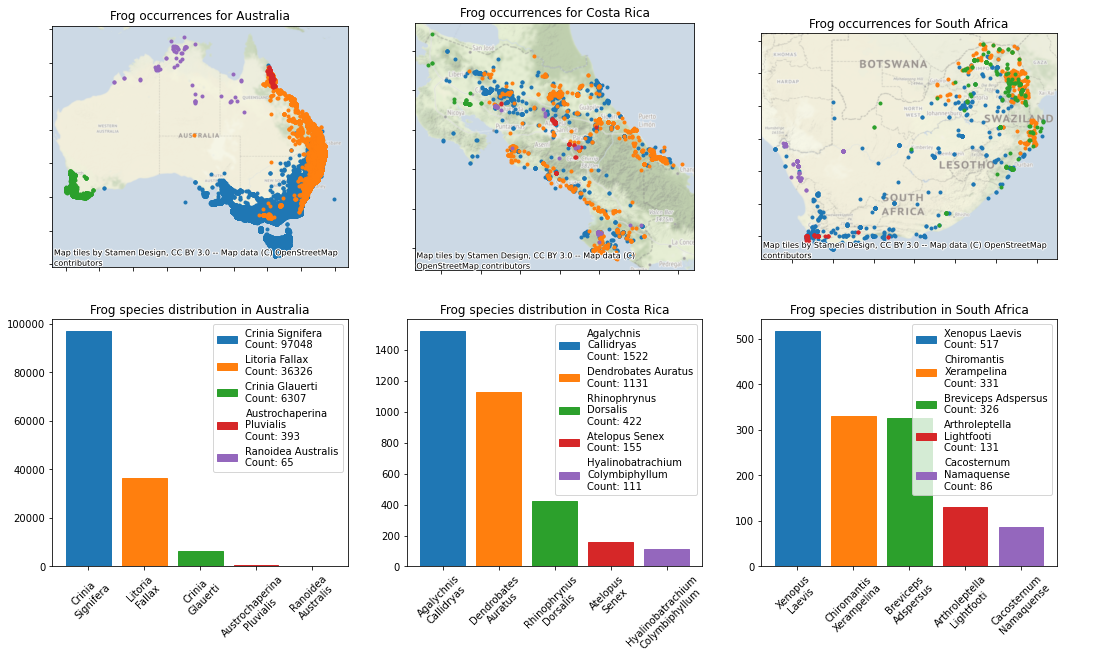

In [29]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))#, gridspec_kw={'height_ratios':[0.7, 0.3]})

for i, cnt in enumerate(data.country.unique()):
    filt = data.country == cnt
    plot_species(fig, ax[:, i], data[filt], cnt)
    
plt.show()

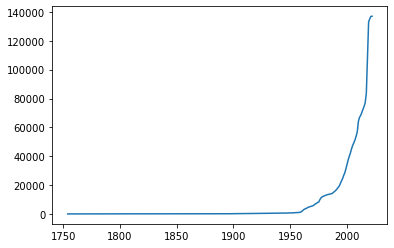

In [98]:
line_data = (
    data
    [['eventDate']]
    .dropna()
    .assign(
        year = lambda x: x.eventDate.dt.year,
        n = 1
    )
    .groupby('year')
    .sum()
    .reset_index()
    .sort_values('year')
    .assign(ncum=lambda x: x.n.cumsum())
)
plt.plot(line_data.year, line_data.ncum)

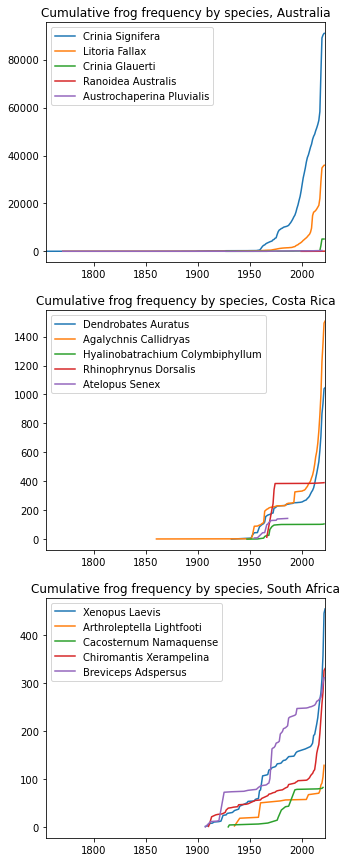

In [117]:
fig, ax = plt.subplots(3, 1, figsize=(5, 15))

for i, cnt in enumerate(data.country.unique()):
    filt = data.country == cnt
    
    for species in data[filt].species.unique():
        line_data = (
            data[filt]
            [lambda x: x.species == species]
            [['eventDate']]
            .dropna()
            .assign(
                year = lambda x: x.eventDate.dt.year,
                n = 1
            )
            .groupby('year')
            .sum()
            .reset_index()
            .sort_values('year')
            .assign(ncum=lambda x: x.n.cumsum())
        )
        ax[i].plot(line_data.year, line_data.ncum, label=species)
    ax[i].legend(loc='upper left')
    ax[i].set_xlim(data.eventDate.dt.year.min(), data.eventDate.dt.year.max())
    ax[i].set_title(f"Cumulative frog frequency by species, {cnt}")
